In [110]:
# just if you run on colab
# link colab and drive
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

In [1]:
# CV project
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import os
import torchvision
from torchvision import datasets, transforms, models
from IPython import display
# import shelve
from PIL import Image
import glob
import matplotlib
from matplotlib.pyplot import *

# if available use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

trainPath = 'Images/train'
testPath =  'Images/test'
dataTrain = torchvision.datasets.ImageFolder(trainPath)
dataTest = torchvision.datasets.ImageFolder(testPath)

im = Image.open(dataTrain.imgs[0][0])

Device: cpu


In [2]:
from torch.utils.data import Dataset, Sampler, DataLoader, SubsetRandomSampler

class customDataset(Dataset):

    def __init__(self, rootPath, transform, data_augmentation=None, augment=False):
        ''' 
          @rootPath: path of the folder containing class subfolders
          @transform: transformation to be applied to each image
          @data_augmentation: further transformations to be applied to train images
          @augment: boolean indicating if data augmentation should be performed
        '''
        self.data = torchvision.datasets.ImageFolder(rootPath)
        self.transform = transform
        self.data_augmentation = data_augmentation
        self.augment = augment
    
    
    
    def __getitem__(self, key):
        true_class = self.data[key][1]
        im = Image.open(self.data.imgs[key][0])
        img_tensor = self.transform(im)
        #print(img_tensor.shape)
        if self.augment and data_augmentation!=None:
            img_tensor = self.data_augmentation(img_tensor)

        return img_tensor, true_class

    def __len__(self):
        return len(self.data)

    def set_augment(self, value):
        self.augment = value

    def change_transform(self, new_transform):
        self.transform = new_transform

    def change_augmentation(self, new_augmentation):
        self.data_augmentation = new_augmentation

    def get_keys(self):
        return range(len(self))


# TRY IF IT WORKS

# just to tensor, i can resize, force to double, normalize, crop, ....
def transform(img):
    t = transforms.Resize([64,64],interpolation=Image.BILINEAR)
    i = t(img)
    i = torch.from_numpy(np.asarray(i).copy())
    i.unsqueeze_(0)
    return i


def data_augmentation(img):
    t = transforms.RandomHorizontalFlip(p=0.5)
    im = t(img)
    return im

d = customDataset(trainPath,transform,augment=False)
a = torchvision.datasets.ImageFolder(trainPath)
print(len(a.imgs))
print(d[0][0])
print(d[0][0].shape)

1500
tensor([[[205, 178, 143,  ..., 102,  85,  62],
         [243, 245, 241,  ..., 109,  96,  76],
         [251, 251, 250,  ..., 112, 104,  89],
         ...,
         [ 42,  44,  44,  ...,  37,  27,  19],
         [ 41,  42,  43,  ...,  43,  36,  28],
         [ 39,  41,  42,  ...,  45,  40,  31]]], dtype=torch.uint8)
torch.Size([1, 64, 64])


In [3]:
import random

def split(dataset, val_size):
    '''
    @ dataset: a customDataset object
    @ val_size: % of validation data
    '''
    index = list(dataset.get_keys())
    val_per_class = int(val_size*100)
    validation_index = []
    for i in range(15):
        idx = random.sample(range(100*i,100*(i+1)),val_per_class)
        validation_index= validation_index + idx
    train_index = list(set(index)-set(validation_index))

    train_sampler = SubsetRandomSampler(train_index)
    validation_sampler = SubsetRandomSampler(validation_index)

    return train_sampler, validation_sampler


def loaders(dataset, val_size, batch_size, num_workers):
    ''' 
    @dataset: a customDataset object
    @val_size: % of validation data
    @batch_size: the number of data in each batch
    @num_workers: number of subprocesses to use in the data loader
    '''
    train_sampler, validation_sampler = split(dataset, val_size)
    train_loader = DataLoader(dataset,
                            batch_size = batch_size,
                            sampler = train_sampler,
                            num_workers = num_workers)
    val_loader = DataLoader(dataset,
                          batch_size = int(len(dataset)*val_size),
                          sampler = validation_sampler,
                          num_workers = num_workers)

    return train_loader, val_loader

tLoad, vLoad = loaders(d,0.15,32,1)
for ii, dd in enumerate(tLoad):
    print(ii)
for ii, dd in enumerate(vLoad):
    print(ii)
print(len(tLoad))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
40


In [33]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.input_dim = 1 * 64 * 64
        self.n_classes = 15
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate')  
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv1.bias)     

        self.maxpooling = nn.MaxPool2d(kernel_size=2,stride=2)  

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv2.bias)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.conv3.bias)

        self.fc1 = nn.Linear(16*16*32,15) # 12*12*32 no padding (default), if padding 16*16*32
        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.fc1.bias)


    def forward(self, x, verbose=False):
        x = F.relu(self.conv1(x))
        x = self.maxpooling(x)
        x = F.relu(self.conv2(x))
        x = self.maxpooling(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # no softmax because crossentropy loss performs it
        return x

# initialize normal weights for linear and convolutional layers
def initialize_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_()
        m.bias.data.fill_(0)
    if type(m) == nn.Conv2d:
        m.weight.data.normal_()
        m.bias.data.fill_(0)

net = CNN()
#net.to(device)

In [117]:
12*12*32

4608

In [34]:
# validation 
def validate(valLoader, net, criterion):
    net.eval()
    correct_count=0
    size = 0
    for i, data in enumerate(valLoader):
        batch = data[0].to(device)
        batch = batch.float()
        labels = data[1].to(device)    

        outputs = net(batch)
        loss = criterion(outputs, labels) 
        predicted_class = torch.argmax(outputs, dim=1)
        correct_count = correct_count + int(sum((predicted_class==labels).int()))
        size = size + batch.shape[0]
    acc = correct_count/size
    net.train()
    return [loss.item(), acc]


# just to tensor and resize, I can normalize, crop, ....
def transform(img):
    t = transforms.Resize([64,64],interpolation=Image.BILINEAR)
    i = t(img)
    i = torch.from_numpy(np.asarray(i).copy())
    i.unsqueeze_(0)
    return i

def data_augmentation(img):
    t = transforms.RandomHorizontalFlip(0.5)
    i=t(img)
    return i

# maybe useful for early stopping
def average_loss(list, window):
    if len(list)<=window:
        return sum(list)/len(list)
    else:
        return sum(list[-window:])/window

In [ ]:
import copy

random.seed(10)
net = CNN()
# train and test sets
trainingSet = customDataset(trainPath, transform, augment=False)
testSet = customDataset(testPath, transform, augment=False)

# train and validation dataloaders
batch_size = 32
num_workers = 1
trainLoader, valLoader = loaders(trainingSet,0.15,batch_size, num_workers)


# parameters
momentum = 0.9
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
patience = 20
validate_each = 5

net.train()
n_batches = len(trainLoader)

def training(net, trainLoader, testLoader, optimizer, criterion, val_patience):
  
    # here I save loss and accuracy
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    # early stopping
    best_net = copy.deepcopy(net.state_dict())
    best_loss = 100.0
    minimum_loss = 100.0
    worsening_count = 0

    net.train()
    batch_size = 32
    validation_size = 0.15
    stop=False
    
    for e in range(epochs):
        #trainLoader, valLoader = loaders(trainingSet,validation_size,batch_size,1)
        #n_batches = len(trainLoader)/batch_size
        for i, data in enumerate(trainLoader):
        
            batch = data[0].to(device)
            batch = batch.float()
            labels = data[1].to(device)    

            optimizer.zero_grad() 
            outputs = net(batch)

            loss = criterion(outputs, labels) 
            train_loss.append(loss.item())
            predicted_class = torch.argmax(outputs, dim=1)
            
            acc = int(sum((predicted_class==labels).int()))/batch.shape[0]
            train_accuracy.append(acc)

            loss.backward()
            optimizer.step()

            if i % validate_each ==0:
                with torch.no_grad():
                    #trainingSet.set_augment(False)
                    valLoss, valAcc = validate(valLoader,net,criterion)
                    val_loss.append(valLoss)
                    val_accuracy.append(valAcc)
                    avg_loss = average_loss(val_loss,7)
                    #trainingSet.set_augment(True)
                               
                if valLoss>best_loss+0.01*best_loss :
                    worsening_count = worsening_count+1
                    if worsening_count >= val_patience:
                        return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]
                else:
                    worsening_count = 0
                    best_loss = valLoss#avg_loss
                    best_net = copy.deepcopy(net.state_dict())
                
                  
                print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: t {}, v {},\t [ACC.]: t {},\t v {}".format(e, i, n_batches, loss.item(), valLoss, acc, valAcc))
  
  # if not early stopped return what I get at the end of the training
    return [best_net, train_loss, val_loss, train_accuracy, val_accuracy]

trained_net, train_loss, valid_loss, train_accuracy, validation_accuracy = training(net,trainLoader,valLoader,optimizer,criterion,patience)


[EPOCH]: 0, [BATCH]: 0/40, [LOSS]: t 2.7086105346679688, v 2.7082366943359375,	 [ACC.]: t 0.15625,	 v 0.05333333333333334
[EPOCH]: 0, [BATCH]: 5/40, [LOSS]: t 2.707624673843384, v 2.7081379890441895,	 [ACC.]: t 0.03125,	 v 0.06222222222222222
[EPOCH]: 0, [BATCH]: 10/40, [LOSS]: t 2.705108165740967, v 2.7080588340759277,	 [ACC.]: t 0.09375,	 v 0.057777777777777775
[EPOCH]: 0, [BATCH]: 15/40, [LOSS]: t 2.707801580429077, v 2.7080047130584717,	 [ACC.]: t 0.03125,	 v 0.057777777777777775
[EPOCH]: 0, [BATCH]: 20/40, [LOSS]: t 2.711151361465454, v 2.707956314086914,	 [ACC.]: t 0.0,	 v 0.06222222222222222
[EPOCH]: 0, [BATCH]: 25/40, [LOSS]: t 2.706084728240967, v 2.7078351974487305,	 [ACC.]: t 0.0625,	 v 0.05333333333333334
[EPOCH]: 0, [BATCH]: 30/40, [LOSS]: t 2.707017660140991, v 2.707751989364624,	 [ACC.]: t 0.0625,	 v 0.04888888888888889
[EPOCH]: 0, [BATCH]: 35/40, [LOSS]: t 2.7085909843444824, v 2.707646369934082,	 [ACC.]: t 0.0625,	 v 0.04888888888888889
[EPOCH]: 1, [BATCH]: 0/40, [LOSS

In [47]:
#plots
index = np.argmin(valid_loss)
print(validation_accuracy[index])

def plot_results(train_data, validation_data, color='C0', isAccuracy = False):
    fig = figure(figsize=(20,10))
    xlim(0,len(train_data)+len(trainLoader))
    
    label1 = 'training_{}'.format('accuracy' if isAccuracy else 'loss')
    label2 = 'validation_{}'.format('accuracy' if isAccuracy else 'loss')
    

    for i in range(0,epochs):
        if (i%2 != 0):
            axvspan(i*len(trainLoader), i*len(trainLoader)+len(trainLoader), facecolor='silver', alpha=0.5)
    ax = subplot(1,1,1)
    l1 = ax.plot(range(0,len(train_data)), train_data, color, label=label1)

    l2 = ax.plot(range(0,len(train_loss), 5), validation_data, 'black', linestyle ='--', dashes=(5, 5),  marker='o',label=label2)
    legend(fontsize=18)
    axvline((len(validation_data)-(patience+1))*validate_each, color='green', linestyle = '--')
    #axvline(index*validate_each,color='red', linestyle = '--')

0.29333333333333333


/home/claudia/Units/AdvancedProgramming/advanced_programming_2019-20/lectures/python/AP/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


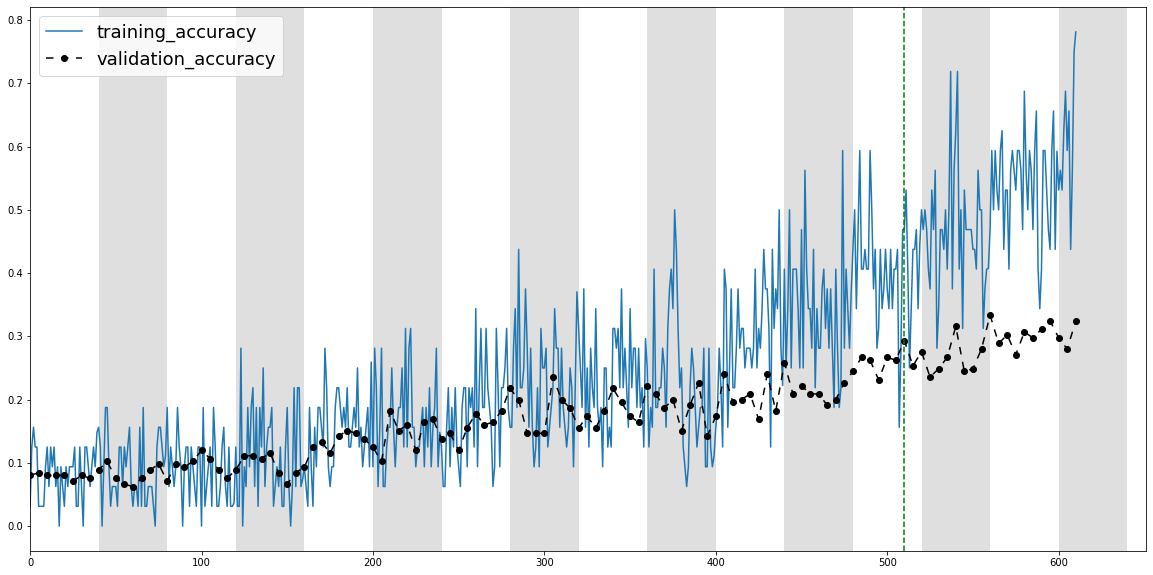

In [48]:
#acc
plot_results(train_accuracy, validation_accuracy,'C0',True)
savefig('plot1')

/home/claudia/Units/AdvancedProgramming/advanced_programming_2019-20/lectures/python/AP/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


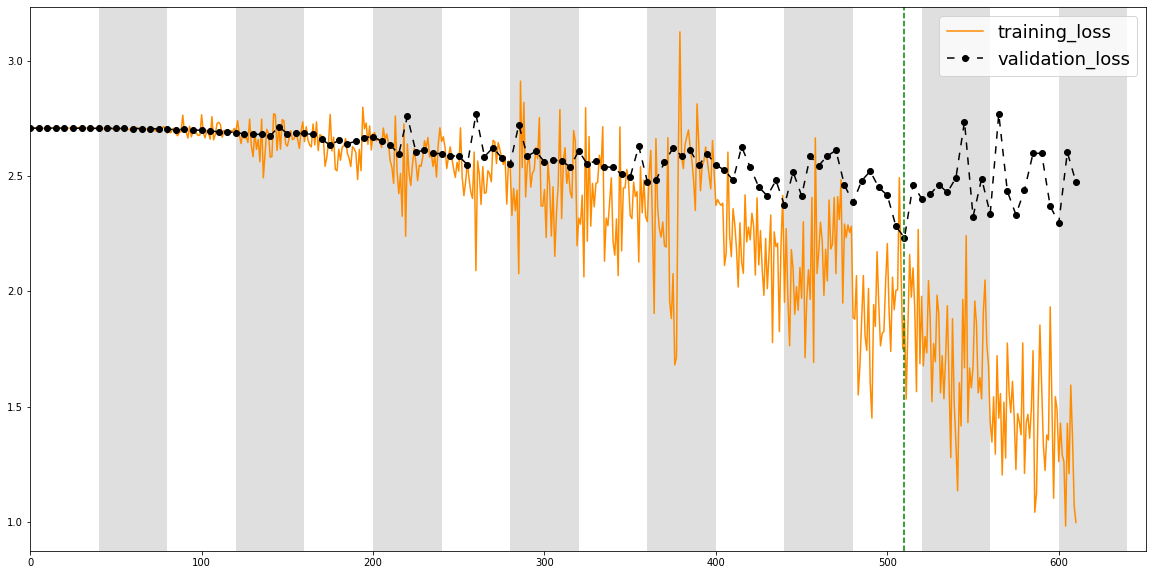

In [49]:
# loss plot
plot_results(train_loss, valid_loss, 'darkorange', False)
savefig('plot2')

In [50]:
# test
# first time we execute this function it's really slow because needs to access new data
# print batch index to check progress

def testing(net, testLoader):
    net.eval()
    with torch.no_grad():
        # to save true and predicted classes
        true_class = []
        predicted_class = []

        for i, data in enumerate(testLoader):
            #print('batch {}'.format(i))
            image = data[0].to(device)
            image = image.float()
            label = data[1].to(device)
            true_class.append(label)
     
            output = net(image)    
            pred_class = torch.argmax(output, dim=1)
            predicted_class.append(pred_class)
                                  
    predicted_class = torch.cat(predicted_class)
    true_class = torch.cat(true_class)    
                                  
    return [true_class, predicted_class]

test acc  0.26867671691792294
Test Accuracy:  0.26867671691792294


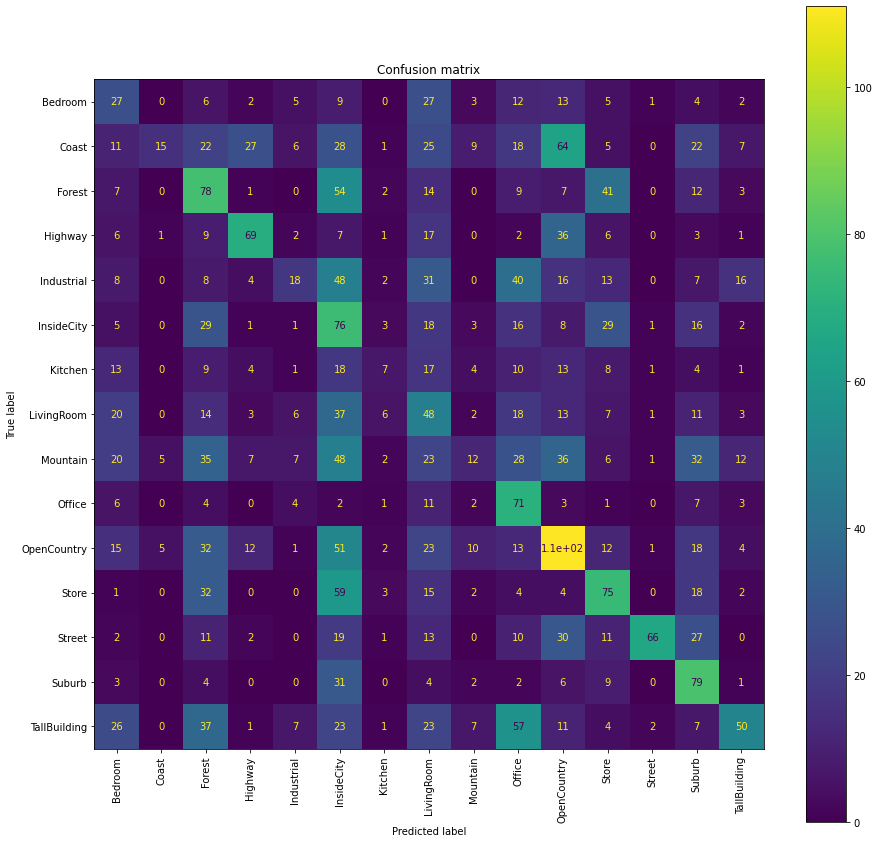

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# test dataloader
testSet.set_augment(False)
testLoader = DataLoader(testSet, batch_size = 32, shuffle=False, num_workers=num_workers)

net.load_state_dict(trained_net)
true_class, predicted_class = testing(net, testLoader) #minimum validation loss
#net2 = CNN()
#net2.load_state_dict(stop_net)
#true_class2, predicted_class2 = testing(net2, testLoader) #early stopping


# accuracy and confusion matrix
acc = int(sum((predicted_class==true_class).int()))/len(predicted_class)
print('test acc ',acc)    
print("Test Accuracy: ", accuracy_score(true_class, predicted_class))
conf_matrix = confusion_matrix(true_class, predicted_class)
disp = ConfusionMatrixDisplay(conf_matrix, dataTest.classes)

fig, ax = subplots(figsize=(15,15))
ax.title.set_text('Confusion matrix')
disp.plot(xticks_rotation='vertical',ax=ax)
savefig('confusion_minimum')


### TRANSFER LEARNING
#### Fine Tuning

In [109]:
#Now using the AlexNet
alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
#print(alexnet)

# set requires_grad false for all parameters
for param in alexnet.parameters():
    param.requires_grad = False
#print(alexnet.classifier[6].weight.data.requires_grad)

# substitute last linear layer with a fully connected one for classification
alexnet.classifier[6] = nn.Linear(4096,15)
#print(alexnet.classifier[6].weight) # only one to have requires_grad = True

# tell the optimizer to learn only weights of this layer
parameters_to_learn = []
for param in alexnet.parameters():
    if param.requires_grad == True:
        parameters_to_learn.append(param)


# this is the required transformation for alexnet
def new_transform(img):
    img = img.convert(mode='RGB') # 3 channels
    t = transforms.Compose([transforms.Resize([224,224]),
                          transforms.ToTensor(), # also transforms in 0,1
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    i = t(img)
    return i

# train and test sets, just need to change the transformation applied
trainingSet.change_transform(new_transform)
testSet.change_transform(new_transform)

# train and validation dataloaders
# I use the same created above

#parameters
optimizer = optim.SGD(parameters_to_learn, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
patience = 5

trained_net, tloss, vloss, tacc, vacc = training(alexnet,trainLoader,valLoader,lr,optimizer,criterion,patience)

Using cache found in /home/claudia/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/claudia/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



[EPOCH]: 0, [BATCH]: 0/40, [LOSS]: t 2.7571916580200195, v 2.8184878826141357,	 [ACC.]: t 0.09375,	 v 0.08
[EPOCH]: 0, [BATCH]: 5/40, [LOSS]: t 2.2826569080352783, v 2.070061206817627,	 [ACC.]: t 0.21875,	 v 0.41333333333333333
[EPOCH]: 0, [BATCH]: 10/40, [LOSS]: t 1.618391752243042, v 1.3889309167861938,	 [ACC.]: t 0.5625,	 v 0.5777777777777777
[EPOCH]: 0, [BATCH]: 15/40, [LOSS]: t 1.1581887006759644, v 0.9695428013801575,	 [ACC.]: t 0.5625,	 v 0.72
[EPOCH]: 0, [BATCH]: 20/40, [LOSS]: t 1.2167267799377441, v 0.7844955325126648,	 [ACC.]: t 0.625,	 v 0.7377777777777778
[EPOCH]: 0, [BATCH]: 25/40, [LOSS]: t 0.726952314376831, v 0.6422579884529114,	 [ACC.]: t 0.75,	 v 0.76
[EPOCH]: 0, [BATCH]: 30/40, [LOSS]: t 0.5100529789924622, v 0.6086703538894653,	 [ACC.]: t 0.78125,	 v 0.7822222222222223
[EPOCH]: 0, [BATCH]: 35/40, [LOSS]: t 0.6820982694625854, v 0.5874179005622864,	 [ACC.]: t 0.71875,	 v 0.8088888888888889
[EPOCH]: 1, [BATCH]: 0/40, [LOSS]: t 0.40600043535232544, v 0.56297832727432

#### Linear SVM using AlexNet as feature extractor

In [2]:
classes = {1:'Bedroom',2:'Coast',3:'Forest',4:'Highway',5:'Industrial',6:'InsideCity',
               7:'Kitchen',8:'LivingRoom',9:'Mountain',10:'Office',11:'OpenCountry',
               12:'Store',13:'Street',14:'Suburb',15:'TallBuilding'}

import torch.nn as nn
from torchvision import models
alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
trainPath = 'Images/train/'
testPath = 'Images/test/'

class feature_extractor(nn.Sequential):
    '''
    take just first part of alexnet to extract features
    '''
    def __init__(self):
        super(feature_extractor, self).__init__()

        self.features = alexnet.features
      
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

def new_transform(img):
    img = img.convert(mode='RGB') # 3 channels
    t = transforms.Compose([transforms.Resize([224,224]),
                          transforms.ToTensor(), # also transforms in 0,1
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    i = t(img)
    return i

def load_images(rootPath,dictionary,transform,net):
    '''
    load all training set
    '''
    all_images = []
    all_labels = []
    for i in range(1,16):
        print('Loading class {}'.format(i))
        path = os.path.join(rootPath,dictionary[i])
        images = [transform(Image.open(os.path.join(path,filename)))for filename in os.listdir(path)]
        images = torch.stack((images))
        labels = np.ones(images.shape[0])*i
        net.eval()
        all_images.append(net(images).detach().numpy())
        all_labels.append(labels)
    return all_images, all_labels
        
net = feature_extractor()
trainX, trainY = load_images(trainPath,classes,new_transform,net)

Using cache found in /home/claudia/.cache/torch/hub/pytorch_vision_v0.6.0


Loading class 1
Loading class 2
Loading class 3
Loading class 4
Loading class 5
Loading class 6
Loading class 7
Loading class 8
Loading class 9
Loading class 10
Loading class 11
Loading class 12
Loading class 13
Loading class 14
Loading class 15


In [35]:
def load_twoClasses(trainX,class1,class2):
    images = np.concatenate((trainX[class1-1],trainX[class2-1]),0)
    
    labels = np.concatenate((np.repeat(-1,trainX[class1-1].shape[0]),
                            np.repeat(1,trainX[class2-1].shape[0])))
    return images, labels

c1 = 9
c2= 5
X, y = load_twoClasses(trainX,c1,c2)
print(X.shape, y.shape)
#y

(200, 9216) (200,)


In [36]:
# try class 9 vs class 5 with scikit because it makes no sense
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)
print(clf.predict(X))
print(clf.dual_coef_.shape)
clf.n_support_
# ok, so there is something wrong in my implementation
# the problem is which vector to use to compute b. with 0 problems, with 1 good
# but which is the criterion? choose a big one? try

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
(1, 74)


array([42, 32], dtype=int32)

In [49]:
solvers.options['show_progress'] = False

def select_C(X,y): # 10-fold cross validation
    C = [1e-5,2e-5,4e-5,6e-5,8e-5,1e-4]
    N = X.shape[0]
    indexes = [i for i in range(N)]
    np.random.shuffle(indexes) 
    idx_blocks = [range((int(N/10)*i),(int(N/10)*(i+1))) for i in range(10)]
    accuracy = np.zeros(len(C))
    for i in range(len(idx_blocks)):

        val_index = [indexes[a] for a in idx_blocks[i]]
        train_index = [indexes[a] for a in ]
        
        valX = X[val_index,:]
        valy = y[val_index]

        tX = X[-val_index,:]
        ty = y[-val_index]
        acc = np.zeros(len(C))
        for c in C:

            sv_X,sv_Y,sv_alpha = train_SVM(tX,ty,c)
            pred = [int(decision_function(valX[i,:].reshape(1,-1),sv_X,sv_Y,sv_alpha)) for i in range(valX.shape[0])]
            corr_class = [pred[i]==int(ty[i]) for i in range(len(pred))]
            acc[c] = sum(corr_class)/len(corr_class)
        accuracy = accuracy + acc
        
    # I should divide to get avg accuracy but to get the maximum it's the same
    ii = np.argmax(accuracy)
    selected_c = C[ii]
    return selected_c
    
select_C(X,y)

TypeError: bad operand type for unary -: 'list'

In [18]:
from cvxopt import matrix, solvers
    

def train_SVM(X,y,C):
    '''
    Having features and labels of 2 classes get the solution of the SVM optimization
    '''
    K = np.matmul(X,X.T)
    # to be element-wise multiplied by yy'
    yyt = np.outer(y,y.T)
    H = np.multiply(yyt,K)

    m,n = X.shape
    # now convert to cvxopt
    P = matrix(H) 
    q = matrix(-np.ones((m, 1))) # column vector of 200 -1 (because in optimization q is transposed and row is needed)
    # subject to
    # two stacked identity matrices with negative and positive diagonal, both size m so 400x200
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m)))) 
    # column vector of m zeros and m ones 400x1
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1)*1.0) # again row vector
    b = matrix(np.zeros(1)) 

    # alpha is a column vector 200x1
    # now I can use these matrices to solve the optimization problem
    solution = solvers.qp(P, q, G, h, A, b)
    # this is the alpha vector
    alpha = np.array(solution['x'])
    # I consider alpha to be different from 0 the alphas > 1e-06
    # so I can find alphas associated with support vectors
    sv_mask = (alpha>1e-6).flatten()
    sv_alpha = alpha[sv_mask]
    
    # this is a matrix containing support vectors (rows=num of sv, columns=num of features)
    sv_X = X[sv_mask,:] # 81x9216
    #and corresponding labels
    sv_Y = y[sv_mask].reshape(-1,1)
    
    return [sv_X,sv_Y,sv_alpha]

def decision_function(x,sv_X,sv_Y,sv_alpha):
    '''
    x is a feature row vector
    returns -1 or 1
    '''
    # first term of decision function, to be summed 
    a1 = np.multiply(sv_Y,sv_alpha)
    a2 = np.matmul(sv_X,x.T)
    s = np.multiply(a1, a2)
    
    # now I need to compute b*
    # I choose one sv xi and b=yi - sumj_sv yj alphai (xj xi)
    index = np.argmax(np.array(sv_alpha))
    #print(index)
    alphaiyj = np.multiply(sv_Y,sv_alpha[index]) #81x1
    xixj = np.matmul(sv_X,sv_X[index,:]).reshape(-1,1) # 81x1
    value = np.multiply(alphaiyj,xixj)
    b = sv_Y[index] - sum(value)
    # so now I have the function inside the threshold
    val = sum(s)+b
    val[val<0] = -1
    val[val>=0] = 1
    return val

svmX, svmY, svmAlpha = train_SVM(X,y,C)
decision_function(X,svmX, svmY, svmAlpha)
#print(len(svmAlpha))

# so find a way to select C: validation set?

NameError: name 'C' is not defined

In [183]:
# test the 2 class accuracy
def twoClassAcc(c1,c2,svmX,svmY,svmAlpha,testPath=testPath,new_transform=new_transform,net=net):
    print('class{} vs class{}'.format(c1,c2))
    predictions = []
    true_lab = []
    for i in [c1,c2]:
        path = os.path.join(testPath,classes[i])
        images = [new_transform(Image.open(os.path.join(path,filename)))for filename in os.listdir(path)]
        images = torch.stack((images))
        #print(images.shape)
        net.eval()
        proc_images = net(images).detach().numpy()
        #print(proc_images.shape)
        pred = [int(decision_function(proc_images[j,:].reshape(1,-1),svmX,svmY,svmAlpha)) for j in range(proc_images.shape[0])]
        #print(pred[0])
        predictions = predictions + pred
        true_lab = true_lab + [-1*(i==c1)+(i==c2)]*len(pred)

    #print(predictions,true_lab)
    corr_class = [predictions[i]==true_lab[i] for i in range(len(predictions))]
    acc = sum(corr_class)/len(corr_class)
    
    return acc

print(twoClassAcc(4,2,svmX, svmY, svmAlpha,testPath=trainPath))
twoClassAcc(4,2,svmX, svmY, svmAlpha)

class4 vs class2
0.985
class4 vs class2


0.8690476190476191

In [184]:
# DON'T RUN, IT'S VERY SLOW, I GOT THE MATRIX BELOW
solvers.options['show_progress'] = False

accuracy = np.zeros((15,15))
print(accuracy)
for c1 in range(2,6):
    for c2 in range(1,c1):
        X, y = load_twoClasses(trainX,c1,c2)
        svmX, svmY, svmAlpha = train_SVM(X,y,C=1)  
        accuracy[c1-1][c2-1] = twoClassAcc(c1,c2,svmX,svmY,svmAlpha)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
class2 vs class1
class3 vs class1
class3 vs class2
class4 vs class1
class4 vs class2
class4 vs class3
class5 vs class1
class5 vs class2
class5 vs class3
class5 vs class4


In [185]:
accuracy

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.69148936, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.6627907 , 0.46721311, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.58333333, 0.86904762, 0.59536082, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.41896024, 0.44798301, 0.48063781, 0.53908356, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [6]:
A = np.matrix([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0],
 [0.97340426,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [1.,0.98360656,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.94927536,0.39761905,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.44342508,0.48407643,0.99088838,0.97843666,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.99691358,0.44444444,1.,0.92934783,0.49642005,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.68584071,1.,0.99704142,0.59259259,0.87538941,0.94968553,0.,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.38032787,0.9064588,0.48920863,0.98853868,0.9025,0.89924433,0.36789298,0.,0.,0.,0.,0.,0.,0.,0.],
 [0.61794872,0.80524345,0.97808765,0.89631336,0.43505155,0.80082988,0.99739583,0.41036717,0.,0.,0.,0.,0.,0.,0.],
 [0.5021645,0.896,0.9941691,1.,0.91104294,0.64396285,0.51111111,0.88157895,1.,0.,0.,0.,0.,0.,0.],
 [1.,0.65087719,0.70446097,0.96595745,0.8925144,1.,1.,0.99599198,0.92465753,1.,0.,0.,0.,0.,0.],
 [0.98791541,0.45263158,1.,0.45333333,0.49530516,0.95271868,0.86461538,0.63613861,0.95501022,0.92121212,0.99809524,0.,0.,0.,0.],
 [0.37662338,0.44247788,0.98809524,0.78125,0.84119107,0.8325,0.7781457,0.82414698,0.41201717,0.6514658,0.96015936,0.79361179,0.,0.,0.],
 [0.6614786,0.94763092,0.88617886,0.7807309,0.40909091,0.78223496,0.56573705,0.83333333,0.3686747,0.55078125,0.92017738,0.76404494,1.,0.,0.],
 [1.,0.99612403,0.96487603,0.84855769,0.54817987,0.44827586,1.,0.9752809,1.,0.83557951,0.94169611,0.54564756,0.99107143,0.93198992,0.]])

def select_classes(class_list, accuracy_matrix):
    '''
    with this function I can select the two easier separable classes on the list
    '''
    mask = np.zeros((15,15))
    for i in class_list:
        for j in class_list:
            mask[i-1][j-1] = 1
    val = np.matrix.argmax(np.multiply(accuracy_matrix,mask))
    i = int(val/15)+1
    j = val%15 +1
    return [i,j]

class_list = [1,3,4]
select_classes(class_list,A)

[3, 1]

#### Multiclass SVM

In [7]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False


def train_all_SVM(class_list,train_data):
    '''
    Solves all pairwise svm optimizations
    '''    
    all_functions = []
    for i in range(1,len(class_list)+1):
        # this list will contain all decision functions for class i vs greater classes
        tmp_list = []
        for j in range(1,i):
            #load data for the 2 classes (features already extracted)
            trainX, Y = load_twoClasses(train_data,i,j)
            #learn SVM with features and Y
            sv_X,sv_Y,sv_alpha = train_SVM(trainX,Y,C=1)
            
            tmp_list.append([sv_X,sv_Y,sv_alpha])
        all_functions.append(tmp_list)
    return all_functions


'''
Recursive structure to implement DAG multiclass classification
A node is characterized by the two classes it classifies, the test function, the left_child, and the right_child
'''
class node():
    #because of how I built A and dag class1>class2
    def __init__(self,class1,class2,test,left,right):
        self.left = left
        self.right = right
        self.class1 = class1
        self.class2 = class2
        self.test = test

    def evaluate(self,x):
        result = test(x,self.class1,self.class2,solutions)
        #print('classes {}vs{} result {}'.format(self.class1,self.class2,result))
        if self.right==None and self.left==None:
            if result ==1:
                return self.class2
            else:
                return self.class1
        else:
            if result == 1:
                return self.right.evaluate(x)
            else:
                return self.left.evaluate(x)
            

def build_dag(class_list):
    return recursive_step(class_list)

def recursive_step(class_list):
  # base case, if just 2 classes return a node with test of the 2 classes and no right and left
  if len(class_list)==2:
    c1,c2 = select_classes(class_list,A)
    return node(c1,c2,test, None, None)
  else:
    # beacause of how I built A c1 is always greater than c2
    c1,c2 = select_classes(class_list,A)
    new_list1 = class_list.copy()
    new_list2 = class_list.copy()
    new_list1.remove(c1)
    new_list2.remove(c2)
    return node(c1,c2,test,recursive_step(new_list2),recursive_step(new_list1))

def test(x, c1, c2, solutions):
    
    # c1>c2
    # so I will get -1 for the minimum class c2, 1 for the maximum c1
    #print(c1,c2)
    sv_x,sv_y,sv_alpha = solutions[c1-1][c2-1]
    result = decision_function(x.reshape(1,-1),sv_x,sv_y,sv_alpha)
    return result
    # in solutions I've stored parameters of class c1 vs c2 where c1 is always greater than c2
    # so if in this call c1 is smaller than c2 I need to change sign to the result
    #if cmin==c1:
    #    return -result
    #else:
    #    return result

net = feature_extractor()
c = [i for i in range(1,5)] 
solutions = train_all_SVM(c,trainX)
dag = build_dag(c)

In [8]:
len(solutions)

4

In [9]:
#trainX = None # just to free some memory

def test_multiclass(c,testPath,solutions,dag,dictionary,transform,net):
    #load one class at the time
    predictions = []
    true_labels = []
    for i in c:
        print('testing class {}'.format(i))
        path = os.path.join(testPath,dictionary[i])
        images = [transform(Image.open(os.path.join(path,filename)))for filename in os.listdir(path)]
        images = torch.stack((images))
        labels = [i]*images.shape[0]
        true_labels = true_labels + labels
        net.eval()
        features = net(images).detach().numpy()
        print('features extracted')
        
        pred = [dag.evaluate(features[ii,:].reshape(1,-1)) for ii in range(features.shape[0])] 
        predictions = predictions+pred
        
    return predictions, true_labels

p, t = test_multiclass(c,testPath,solutions,dag,classes,new_transform,net)        

testing class 1
hello
features extracted
testing class 2
hello
features extracted
testing class 3
hello
features extracted
testing class 4
hello
features extracted


In [11]:
corr_class = [p[i]==t[i] for i in range(len(p))]
acc = sum(corr_class)/len(corr_class)
acc
print(p)
# class 2 is predicted as 4, why???
# need to understand why binary classifier doesn't work

[4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)